# Parkinson's Disease Detector with Apache Cassandra and PySpark Machine Learning

#### Jupyter notebook inspired by the template at https://github.com/datastaxdevs/workshop-machine-learning/blob/master/jupyter/Random%20Forest.ipynb

In [229]:
!pip3 install matplotlib --quiet
!pip3 install ipykernel --quiet

In [230]:
!pip install cassandra-driver --quiet
!pip install pyspark==3.4.1 --quiet

In [231]:
!python3 -m ipykernel install --user --name=vs-l-pd-detector

Installed kernelspec vs-l-pd-detector in /Users/mariannelynemanaog/Library/Jupyter/kernels/vs-l-pd-detector


In [232]:
!PYDEVD_DISABLE_FILE_VALIDATION=1

In [233]:
import os
import random
import re
import warnings

import cassandra
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyspark
import seaborn as sns

from IPython.display import display, Markdown
from random import randint, randrange

from cassandra.cluster import Cluster
from cassandra.policies import DCAwareRoundRobinPolicy

from pyspark.sql import SparkSession

from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier, GBTClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import IndexToString, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from scipy import stats

In [234]:
warnings.filterwarnings('ignore')
%matplotlib inline

## Set up Apache Cassandra

In [235]:
# Install the latest version of Cassandra (4.1.3) from https://www.apache.org/dyn/closer.lua/cassandra/4.1.3/apache-cassandra-4.1.3-bin.tar.gz

In [ ]:
# Install GPG to verify the hash of the downloaded tarball
!arch -arm64 brew install gnupg gnupg2

# Link GPG
!brew link gnupg

!gpg --print-md SHA256 apache-cassandra-4.1.3-bin.tar.gz

In [237]:
# Compare the signature with the SHA256 file from the Downloads site
!curl -L https://downloads.apache.org/cassandra/4.1.3/apache-cassandra-4.1.3-bin.tar.gz.sha256

da014999723f4e1e2c15775dac6aaa9ff69a48f6df6465740fcd52ca9d19ea88


In [ ]:
Unpack the tarball
!tar xzvf apache-cassandra-4.1.3-bin.tar.gz

In [240]:
os.chdir('apache-cassandra-4.1.3')

In [241]:
!pwd

/Users/mariannelynemanaog/PycharmProjects/vs-ml-pd-detector/notebooks/apache-cassandra-4.1.3


In [242]:
!bin/cassandra

In [243]:
# Verify cassandra installation by checking its version number
!cassandra -v

4.1.3


In [244]:
# Start the cassandra server on the terminal
!cassandra -f

## Creating and loading tables

### Connect to Cassandra

In [245]:
# Get the IP address by running 'cqlsh' on the terminal
cluster = Cluster(['127.0.0.1'], protocol_version=5, load_balancing_policy=DCAwareRoundRobinPolicy())
session = cluster.connect()

### Create keyspace 

In [246]:
session.execute("""
    CREATE KEYSPACE IF NOT EXISTS parkinson 
    WITH REPLICATION = 
    { 'class' : 'SimpleStrategy', 'replication_factor' : 1 }"""
)

### Set keyspace 

In [247]:
session.set_keyspace('parkinson')

### Create two tables called `speech_data_train` and `speech_data_test` containing the train and test sets respectively. The PRIMARY will be a unique key (subject_id) for each row.

In [248]:
query = "CREATE TABLE IF NOT EXISTS speech_data_train \
                                   (subject_id text, jitter_percent float, jitter_abs float, rap float, ppq float, \
                                   apq_3 float, apq_5 float, apq_11 float, status int, \
                                   PRIMARY KEY (subject_id))"
session.execute(query)

In [249]:
query = "CREATE TABLE IF NOT EXISTS speech_data_test \
                                   (subject_id text, jitter_percent float, jitter_abs float, rap float, ppq float, \
                                   apq_3 float, apq_5 float, apq_11 float, status int, \
                                   PRIMARY KEY (subject_id))"
session.execute(query)

### Load the train and test datasets from csv files

#### Insert train and test speech data into the tables `speech_data_train` and `speech_data_test` respectively

In [250]:
fileName = '/Users/mariannelynemanaog/PycharmProjects/vs-ml-pd-detector/src/data/train_and_test_sets/train_data.csv'
input_file = open(fileName, 'r')
i = 1
for line_number, line in enumerate(input_file):
    if line_number == 0:
        continue  # Skip the first line, as it has the header with the column names
    subject_id = i
    row = line.replace('\n', "").split(',')
    
    query = "INSERT INTO speech_data_train (subject_id, jitter_percent, jitter_abs, rap, ppq, \
                               apq_3, apq_5, apq_11, status)"
    query = query + " VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)"
    session.execute(query, (str(row[0]), float(row[1]), float(row[2]), float(row[3]), float(row[4]), float(row[5]), float(row[6]), float(row[7]), int(row[8])))
    i = i + 1

fileName = '/Users/mariannelynemanaog/PycharmProjects/vs-ml-pd-detector/src/data/train_and_test_sets/test_data.csv'
input_file = open(fileName, 'r')

for line_number, line in enumerate(input_file):
    if line_number == 0:
        continue  # Skip the first line, as it has the header with the column names
    subject_id = i
    row = line.replace('\n', "").split(',')
        
    query = "INSERT INTO speech_data_test (subject_id, jitter_percent, jitter_abs, rap, ppq, \
                               apq_3, apq_5, apq_11, status)"
    query = query + " VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)"
    session.execute(query, (str(row[0]), float(row[1]), float(row[2]), float(row[3]), float(row[4]), float(row[5]), float(row[6]), float(row[7]), int(row[8])))
    i = i + 1
    

## Machine Learning with Apache Cassandra and Apache Spark

#### Create a spark session that is connected to the database. Then, load each table into a Spark Dataframe and take a count of the number of rows in each.

In [251]:
spark = SparkSession.builder.appName('demo').master("local").getOrCreate()

In [252]:
spark

In [253]:
rows_train = session.execute('select * from speech_data_train;')
df_train = pd.DataFrame(list(rows_train))

rows_test = session.execute('select * from speech_data_test;')
df_test = pd.DataFrame(list(rows_test))

#### Identify and remove multi-collinear features

In [254]:
# Calculate the correlation matrix on the numeric columns
corr = df_train.corr(method='kendall')

corr

,apq_11,apq_3,apq_5,jitter_abs,jitter_percent,ppq,rap,status
apq_11,1.000000,0.052892,0.019032,0.012825,-0.130432,-0.040990,-0.007268,0.046021
apq_3,0.052892,1.000000,0.723559,0.646277,0.539519,0.763585,0.652425,-0.101047
apq_5,0.019032,0.723559,1.000000,0.631294,0.548759,0.842134,0.658644,-0.140040
jitter_abs,0.012825,0.646277,0.631294,1.000000,0.743401,0.676145,0.876982,-0.066838
jitter_percent,-0.130432,0.539519,0.548759,0.743401,1.000000,0.578950,0.852491,-0.130294
ppq,-0.040990,0.763585,0.842134,0.676145,0.578950,1.000000,0.702596,-0.138054
rap,-0.007268,0.652425,0.658644,0.876982,0.852491,0.702596,1.000000,-0.086286
status,0.046021,-0.101047,-0.140040,-0.066838,-0.130294,-0.138054,-0.086286,1.000000


<AxesSubplot:>

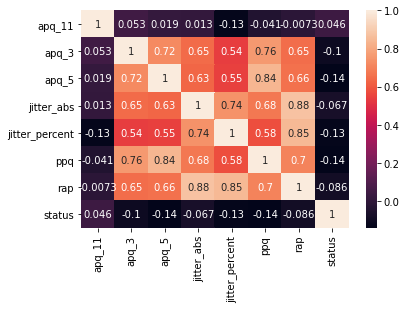

In [255]:
# Plot the heatmap
sns.heatmap(corr, annot=True)

The features that bring unique information to discriminate between pathophysiological and healthy speech patterns 
are the following ones:
- apq11, as no other numeric features are highly correlated with it
- apq3, whilst the multi-collinear (e.g., > 0.7) apq5 and ppq are suggested to be removed since they are not adding 
any further unique information with respect to apq3
- jitter_percent, whilst the multi-collinear (e.g., > 0.7) jitter_abs and rap are suggested to be removed since they are not adding any further unique information with respect to jitter_percent.

In [256]:
unique_feats_to_retain = ['subject_id', 'apq_11', 'apq_3', 'jitter_percent', 'status']
df_train = df_train[unique_feats_to_retain]

In [257]:
df_train.head()

,subject_id,apq_11,apq_3,jitter_percent,status
0,phon_R01_S10_3,0.010330,0.007770,0.00210,0
1,phon_R01_S32_2,0.009030,0.004760,0.00270,1
2,CONT-11,0.039913,0.030384,0.53133,0
3,0.000157842,0.819181,18.808001,0.58300,1
4,9.8239e-05,0.887069,11.811000,0.74200,1


In [258]:
df_train.describe()

,apq_11,apq_3,jitter_percent,status
count,1503.000000,1503.000000,1503.000000,1503.000000
mean,1.405134,8.734374,0.889277,0.596141
std,2.872461,7.265618,0.982743,0.490833
min,0.006070,0.003630,0.000005,0.000000
25%,0.682797,2.183000,0.015595,0.000000
50%,0.840368,8.649000,0.696000,1.000000
75%,0.911487,13.412000,1.299000,1.000000
max,39.007999,44.764000,8.016000,1.000000


#### Remove outliers from train and test sets via z-scores

In [259]:
columns_to_process = ['apq_11', 'apq_3', 'jitter_percent']

z_score_thresh_train = 3.5
z_score_thresh_test = 1

for col in columns_to_process:
    df_train = df_train[(np.abs(stats.zscore(df_train[col])) < z_score_thresh_train)]

In [260]:
df_train.describe()

,apq_11,apq_3,jitter_percent,status
count,1446.000000,1446.000000,1446.000000,1446.000000
mean,1.104668,8.515723,0.834364,0.587828
std,1.720087,6.939063,0.792473,0.492396
min,0.006070,0.003630,0.000005,0.000000
25%,0.683534,1.892500,0.098000,0.000000
50%,0.840173,8.643000,0.701500,1.000000
75%,0.907474,13.280250,1.268750,1.000000
max,11.245000,33.550999,4.158000,1.000000


In [261]:
df_test = df_test[unique_feats_to_retain]

In [262]:
df_test.head()

,subject_id,apq_11,apq_3,jitter_percent,status
0,151,0.08309,0.04866,0.00870,1
1,6,0.02123,0.01087,0.00084,1
2,191,0.03954,0.02140,0.00121,1
3,210,0.06352,0.02399,0.00097,0
4,90,0.10453,0.07051,0.00576,1


In [263]:
df_test.describe()

,apq_11,apq_3,jitter_percent,status
count,252.000000,252.000000,252.000000,252.000000
mean,0.053749,0.034021,0.002263,0.746032
std,0.031213,0.022342,0.002632,0.436146
min,0.005220,0.003350,0.000210,0.000000
25%,0.029327,0.017240,0.000998,0.000000
50%,0.047195,0.027325,0.001440,1.000000
75%,0.071335,0.044585,0.002395,1.000000
max,0.167680,0.130510,0.027750,1.000000


In [264]:
for col in columns_to_process:
    df_test = df_test[(np.abs(stats.zscore(df_test[col])) < z_score_thresh_test)]

In [265]:
df_test.describe()

,apq_11,apq_3,jitter_percent,status
count,117.000000,117.000000,117.000000,117.000000
mean,0.043668,0.026562,0.001416,0.777778
std,0.013817,0.007969,0.000582,0.417528
min,0.022980,0.014900,0.000510,0.000000
25%,0.032480,0.020490,0.001030,1.000000
50%,0.041140,0.025030,0.001370,1.000000
75%,0.054670,0.032740,0.001800,1.000000
max,0.081370,0.044930,0.003160,1.000000


In [266]:
df_train['status'].value_counts()

1    850
0    596
Name: status, dtype: int64

In [267]:
df_test['status'].value_counts()

1    91
0    26
Name: status, dtype: int64

In [268]:
print("Train Table Speech Data Row Count: ")
print(len(df_train))

Train Table Speech Data Row Count: 
1446


In [269]:
print("Test Table Speech Data Row Count: ")
print(len(df_test))

Test Table Speech Data Row Count: 
117


In [270]:
# Create PySpark DataFrames from Pandas
print('The PySpark train df is: ')
sparkDF_train=spark.createDataFrame(df_train) 
sparkDF_train.printSchema()
sparkDF_train.show()

print('The PySpark test df is: ')
sparkDF_test=spark.createDataFrame(df_test) 
sparkDF_test.printSchema()
sparkDF_test.show()

The PySpark train df is: 
root
 |-- subject_id: string (nullable = true)
 |-- apq_11: double (nullable = true)
 |-- apq_3: double (nullable = true)
 |-- jitter_percent: double (nullable = true)
 |-- status: long (nullable = true)

+--------------+--------------------+--------------------+--------------------+------+
|    subject_id|              apq_11|               apq_3|      jitter_percent|status|
+--------------+--------------------+--------------------+--------------------+------+
|phon_R01_S10_3|0.010329999960958958|0.007770000025629997|0.002099999925121665|     0|
|phon_R01_S32_2|0.009030000306665897|0.004759999923408...|0.002700000070035...|     1|
|       CONT-11| 0.03991299867630005| 0.03038400039076805|  0.5313299894332886|     0|
|   0.000157842|  0.8191810250282288|  18.808000564575195|  0.5830000042915344|     1|
|    9.8239e-05|  0.8870689868927002|  11.810999870300293|  0.7419999837875366|     1|
|   0.000274444|  0.8325780034065247|   8.017999649047852|   2.7349998950

In [271]:
def visualise_df(input_df: pd.DataFrame, limitRows: int = 5, truncate: bool = True) -> None:
    """
    Visualise the first n rows of a Spark df while truncating the columns' width (if True).
    
    Args:
       input_df: pd.DataFrame
           An input df to visualise.
       limitRows: int
           The number of rows to show.
       truncate: bool
           If True (by default), truncate the columns' width.
    """
    if(truncate):
        pd.set_option('display.max_colwidth', 50)
    else:
        pd.set_option('display.max_colwidth', -1)
    pd.set_option('display.max_rows', limitRows)
    display(input_df.limit(limitRows).toPandas())
    pd.reset_option('display.max_rows')

#### Create vectors with all elements of the speech datasets

In [272]:
assembler = VectorAssembler(
    inputCols=['jitter_percent', 'apq_3', 'apq_11'],
    outputCol='features'
)

trainingData = assembler.transform(sparkDF_train)

labelIndexer_train = StringIndexer(inputCol="status", outputCol="label", handleInvalid='keep')
train = labelIndexer_train.fit(trainingData).transform(trainingData)

visualise_df(train)
print(train.count())

testingData = assembler.transform(sparkDF_test)

labelIndexer_test = StringIndexer(inputCol="status", outputCol="label", handleInvalid='keep')
test = labelIndexer_test.fit(testingData).transform(testingData)

visualise_df(test)
print(test.count())

,subject_id,apq_11,apq_3,jitter_percent,status,features,label
0,phon_R01_S10_3,0.010330,0.007770,0.00210,0,"[0.002099999925121665, 0.007770000025629997, 0...",1.0
1,phon_R01_S32_2,0.009030,0.004760,0.00270,1,"[0.0027000000700354576, 0.0047599999234080315,...",0.0
2,CONT-11,0.039913,0.030384,0.53133,0,"[0.5313299894332886, 0.03038400039076805, 0.03...",1.0
3,0.000157842,0.819181,18.808001,0.58300,1,"[0.5830000042915344, 18.808000564575195, 0.819...",0.0
4,9.8239e-05,0.887069,11.811000,0.74200,1,"[0.7419999837875366, 11.810999870300293, 0.887...",0.0


1446


,subject_id,apq_11,apq_3,jitter_percent,status,features,label
0,191,0.03954,0.02140,0.00121,1,"[0.0012100000167265534, 0.021400000900030136, ...",0.0
1,210,0.06352,0.02399,0.00097,0,"[0.0009699999936856329, 0.023989999666810036, ...",1.0
2,163,0.02824,0.02610,0.00141,0,"[0.0014100000262260437, 0.026100000366568565, ...",1.0
3,200,0.03051,0.02203,0.00210,1,"[0.002099999925121665, 0.022029999643564224, 0...",0.0
4,144,0.04161,0.02268,0.00108,1,"[0.00107999995816499, 0.022679999470710754, 0....",0.0


117


### Train a Gradient-Boosted Tree model whilst preserving the train and test sets generated above, which prevent both time-related data leakage and do not have any overlapping subjects between train and test sets. 

### The optimal hyperparameters were obtained via grid search optimisation when cross-validating the model during training.

In [296]:
# stepSize is the learning rate and a low value can improve the predictive performance 
# of a gradient boosting model.
# subsamplingRate is the percentage of training data used for learning in each decision tree.
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=15, seed=13,
                   maxDepth=6, stepSize=0.01, maxBins=145, subsamplingRate=0.7)

pipeline = Pipeline(stages=[gbt])

paramGrid = (ParamGridBuilder().addGrid(
    param=gbt.validationTol, values=[0.1, 0.01, 0.05]).build())

weighted_recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                              metricName="weightedRecall")

gbt_crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=weighted_recall_evaluator)

gbt_model = gbt_crossval.fit(train)

predictions_from_GBT = gbt_model.transform(test)

print(predictions_from_GBT.count())
visualise_df(predictions_from_GBT)

117


,subject_id,apq_11,apq_3,jitter_percent,status,features,label,rawPrediction,probability,prediction
0,191,0.03954,0.02140,0.00121,1,"[0.0012100000167265534, 0.021400000900030136, ...",0.0,"[1.0907984820379764, -1.0907984820379764]","[0.8985846964841182, 0.1014153035158818]",0.0
1,210,0.06352,0.02399,0.00097,0,"[0.0009699999936856329, 0.023989999666810036, ...",1.0,"[1.0907984820379764, -1.0907984820379764]","[0.8985846964841182, 0.1014153035158818]",0.0
2,163,0.02824,0.02610,0.00141,0,"[0.0014100000262260437, 0.026100000366568565, ...",1.0,"[-0.9197713013547661, 0.9197713013547661]","[0.13710539712710162, 0.8628946028728983]",1.0
3,200,0.03051,0.02203,0.00210,1,"[0.002099999925121665, 0.022029999643564224, 0...",0.0,"[1.0907984820379764, -1.0907984820379764]","[0.8985846964841182, 0.1014153035158818]",0.0
4,144,0.04161,0.02268,0.00108,1,"[0.00107999995816499, 0.022679999470710754, 0....",0.0,"[1.0907984820379764, -1.0907984820379764]","[0.8985846964841182, 0.1014153035158818]",0.0


In [299]:
# Predictions for the training set
predictions_from_GBT_train = gbt_model.transform(train)

print(predictions_from_GBT_train.count())
visualise_df(predictions_from_GBT_train)

1446


,subject_id,apq_11,apq_3,jitter_percent,status,features,label,rawPrediction,probability,prediction
0,phon_R01_S10_3,0.010330,0.007770,0.00210,0,"[0.002099999925121665, 0.007770000025629997, 0...",1.0,"[-0.3280711551707878, 0.3280711551707878]","[0.3416067196751755, 0.6583932803248245]",1.0
1,phon_R01_S32_2,0.009030,0.004760,0.00270,1,"[0.0027000000700354576, 0.0047599999234080315,...",0.0,"[0.9938570195592007, -0.9938570195592007]","[0.8795010839430571, 0.12049891605694285]",0.0
2,CONT-11,0.039913,0.030384,0.53133,0,"[0.5313299894332886, 0.03038400039076805, 0.03...",1.0,"[-0.3195051195011482, 0.3195051195011482]","[0.3454703104761629, 0.654529689523837]",1.0
3,0.000157842,0.819181,18.808001,0.58300,1,"[0.5830000042915344, 18.808000564575195, 0.819...",0.0,"[-0.7838004055566715, 0.7838004055566715]","[0.172558684097611, 0.827441315902389]",1.0
4,9.8239e-05,0.887069,11.811000,0.74200,1,"[0.7419999837875366, 11.810999870300293, 0.887...",0.0,"[-0.07244051105711045, 0.07244051105711045]","[0.46384296856885837, 0.5361570314311417]",1.0


In [297]:
best_gbt_model = gbt_model.bestModel
print('Best validation tol: ', best_gbt_model.stages[-1]._java_obj.parent().getValidationTol())

Best validation tol:  0.1


### Leverage the MulticlassClassificationEvaluator to evaluate the accuracy and reliability of the predictions obtained via the Gradient Boosted Tree model. 

In [298]:
# Compute key evaluation metrics on the test set, i.e., accuracy, 
# weightedPrecision, weightedRecall, weightedFMeasure

precision_vals = 3

accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                              metricName="accuracy")
accuracy_GBT = accuracy_evaluator.evaluate(predictions_from_GBT)
print("Test set accuracy for the Gradient-Boosted Tree = " + str(round(accuracy_GBT, precision_vals)))

weighted_precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                              metricName="weightedPrecision")
weighted_precision_GBT = weighted_precision_evaluator.evaluate(predictions_from_GBT)
print("Test set weighted precision for the Gradient-Boosted Tree = " + str(round(weighted_precision_GBT, precision_vals)))

# Recall is also named as 'sensitivity' or 'true positive rate', and is the key metric to increase in this project.
weighted_recall_GBT = weighted_recall_evaluator.evaluate(predictions_from_GBT)
print("Test set weighted recall for the Gradient-Boosted Tree = " + str(round(weighted_recall_GBT, precision_vals)))

# F-measure is also named as 'F-score' or 'F1-score', and is the harmonic mean between precision and recall.
weighted_f_measure_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                              metricName="weightedFMeasure")
weighted_f_measure_GBT = weighted_f_measure_evaluator.evaluate(predictions_from_GBT)
print("Test set weighted F-measure for the Gradient-Boosted Tree = " + str(round(weighted_f_measure_GBT, precision_vals)))

Test set accuracy for the Gradient-Boosted Tree = 0.795
Test set weighted precision for the Gradient-Boosted Tree = 0.838
Test set weighted recall for the Gradient-Boosted Tree = 0.795
Test set weighted F-measure for the Gradient-Boosted Tree = 0.719


In [300]:
# Compute key evaluation metrics on the train set, i.e., accuracy, 
# weightedPrecision, weightedRecall, weightedFMeasure

accuracy_GBT_train = accuracy_evaluator.evaluate(predictions_from_GBT_train)
print("Train set accuracy for the Gradient-Boosted Tree = " + str(round(accuracy_GBT_train, precision_vals)))

weighted_precision_GBT_train = weighted_precision_evaluator.evaluate(predictions_from_GBT_train)
print("Train set weighted precision for the Gradient-Boosted Tree = " + str(round(weighted_precision_GBT_train, precision_vals)))

weighted_recall_GBT_train = weighted_recall_evaluator.evaluate(predictions_from_GBT_train)
print("Train set weighted recall for the Gradient-Boosted Tree = " + str(round(weighted_recall_GBT_train, precision_vals)))

weighted_f_measure_GBT_train = weighted_f_measure_evaluator.evaluate(predictions_from_GBT_train)
print("Train set weighted F-measure for the Gradient-Boosted Tree = " + str(round(weighted_f_measure_GBT_train, precision_vals)))

Train set accuracy for the Gradient-Boosted Tree = 0.735
Train set weighted precision for the Gradient-Boosted Tree = 0.746
Train set weighted recall for the Gradient-Boosted Tree = 0.735
Train set weighted F-measure for the Gradient-Boosted Tree = 0.737


### Insights on predictive performance on the (unseen) test set

The initial set of metrics (from the [PR no. 2](https://github.com/marianne-manaog/vs-ml-pd-detector/pull/2)) of a Random Forest (RF) model, using 
80% and 20% of the data split randomly between the train and test sets but without training the model via cross-validation, was as follows:
- Test set accuracy = 0.709
- Test set weighted precision = 0.706
- Test set weighted recall = 0.709
- Test set weighted F-measure = 0.707

The second set of metrics (from the [PR no. 3](https://github.com/marianne-manaog/vs-ml-pd-detector/pull/3)) of a RF model, using the previously generated data splits to avoid time- and subject-related data leakage (2008-2016 data for training, 2018 data on different subjects for testing) but without training the model via cross-validation, was as follows:
- Test set accuracy = 0.75
- Test set weighted precision = 0.706
- Test set weighted recall = 0.75
- Test set weighted F-measure = 0.691

The third set of metrics (from the [PR no. 4](https://github.com/marianne-manaog/vs-ml-pd-detector/pull/4)) of a RF model, using the previously generated data splits to avoid time- and subject-related data leakage (2008-2016 data for training, 2018 data on different subjects for testing) but training the model with cross-validation, was as follows:
- Test set accuracy = 0.75
- Test set weighted precision = 0.813
- Test set weighted recall = 0.75
- Test set weighted F-measure = 0.647

The fourth set of metrics (from the [PR no. 5](https://github.com/marianne-manaog/vs-ml-pd-detector/pull/5)) of a Gradient-Boosted Tree (GBT) model, using the previously generated data splits to avoid time- and subject-related data leakage (2008-2016 data for training, 2018 data on different subjects for testing) but training the model with cross-validation, was as follows:
- Test set accuracy = 0.762
- Test set weighted precision = 0.737
- Test set weighted recall = 0.762
- Test set weighted F-measure = 0.7

I.e., the following predictive performance changes have been achieved between the third (RF) and fourth (GBT) set of metrics:
- Increased accuracy by 1.2%
- Decreased weighted precision by 7.6%
- Increased weighted recall by 1.2%
- Increased weighted F-measure by 5.3%

Thus, overall and considering that the weighted recall is the key metric to increase in this project, the predictive performance of the GBT model was found slightly higher than the RF and the Decision Tree models. Thus, the GBT model was selected as the optimal one for this project.

In this notebook (from the [PR no. 6](https://github.com/marianne-manaog/vs-ml-pd-detector/pull/6)), multi-collinear features were identified and discarded, thus leading to retain the top three predictors for model training, i.e., apq_11, apq_3, jitter_percent. Furthermore, outliers were detected and removed via the z-scores-based method. The final GBT model's predictive performance on the test set was as follows, which is slightly higher than its training performance, indicating a promising generalisation on unseen data: 
- Test set accuracy = 0.795, 3.3% higher than the previous version
- Test set weighted precision = 0.838, 10.1% higher than the previous version
- Test set weighted recall = 0.795, 3.3% higher than the previous version
- Test set weighted F-measure = 0.719, 1.9% higher than the previous version

In [275]:
session.execute("""drop table speech_data""")